In [166]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["font.size"] = 10

import superscreen as sc
from superscreen.geometry import box, circle, rotate
sc.version_table()

Software,Version
SuperScreen,0.12.1
Numpy,2.0.2
Numba,0.60.0
SciPy,1.13.1
matplotlib,3.9.4
IPython,8.18.1
Python,"3.9.0 (tags/v3.9.0:9cf6752, Oct 5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]"
OS,nt [win32]
Number of CPUs,"Physical: 16, Logical: 22"
BLAS Info,Generic


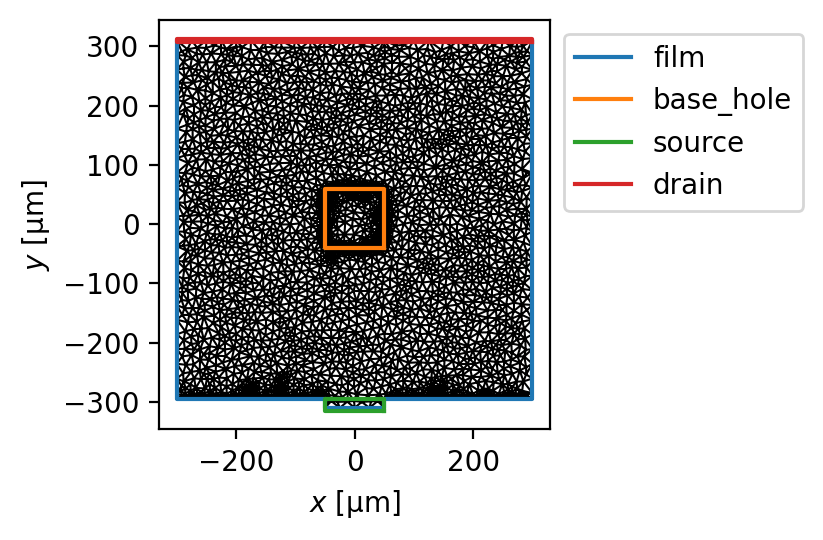

In [167]:
width = 600
height = 620
slot_height =20
slot_width = 250
x0, y0 = center = (0, 0)
length_units = "um"
slit_width=10
slit_height=540
hole_width=100
hole_height=100
layer=sc.Layer("base", Lambda=0.9)
film = sc.Polygon("film", layer="base", points=box(width, height))
slot = sc.Polygon(
    points=box(slot_width, slot_height, center=(-175,-305))
    
)
film = film.difference(slot, slot.scale(xfact=-1))


drain_terminal = sc.Polygon(
    "drain", points=box(width, height / 100, center=(0, height / 2))
)
source_terminal =  sc.Polygon(
    "source", points=box(100,20, center=(0, -305))
)

device = sc.Device(
    "constriction",
    layers=[layer],
    films=[film],
    terminals={film.name: [source_terminal, drain_terminal]},
    length_units=length_units,
)
device.holes = {
    "base_hole": sc.Polygon( "base_hole",layer="base", 
    points=box(hole_width, hole_height, center=(0,10)))
}

device.make_mesh(min_points=3000, smooth=0)
fig, ax = device.plot_mesh(edge_color="k", show_sites=False)
_ = device.plot_polygons(ax=ax, legend=True)
#fig, ax = device.draw(legend=True)

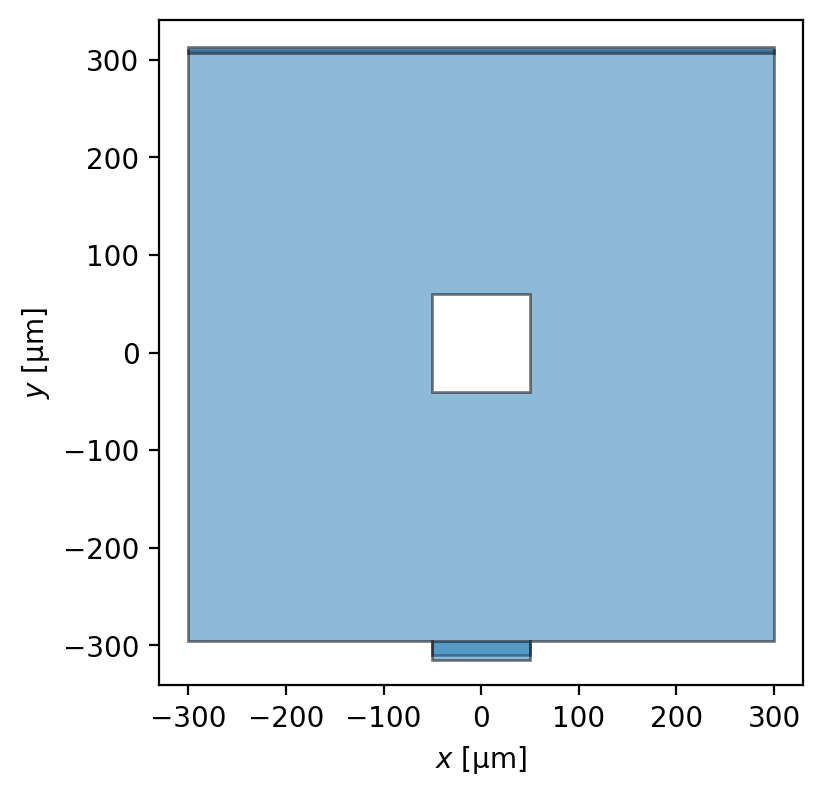

In [168]:
_=device.draw()

In [169]:
terminal_currents = {"film": {"source": "100 uA", "drain": "-100 uA"}}

solution = sc.solve(
    device,
    applied_field=sc.sources.ConstantField(0),
    terminal_currents=terminal_currents,
    current_units="uA",
)[-1]

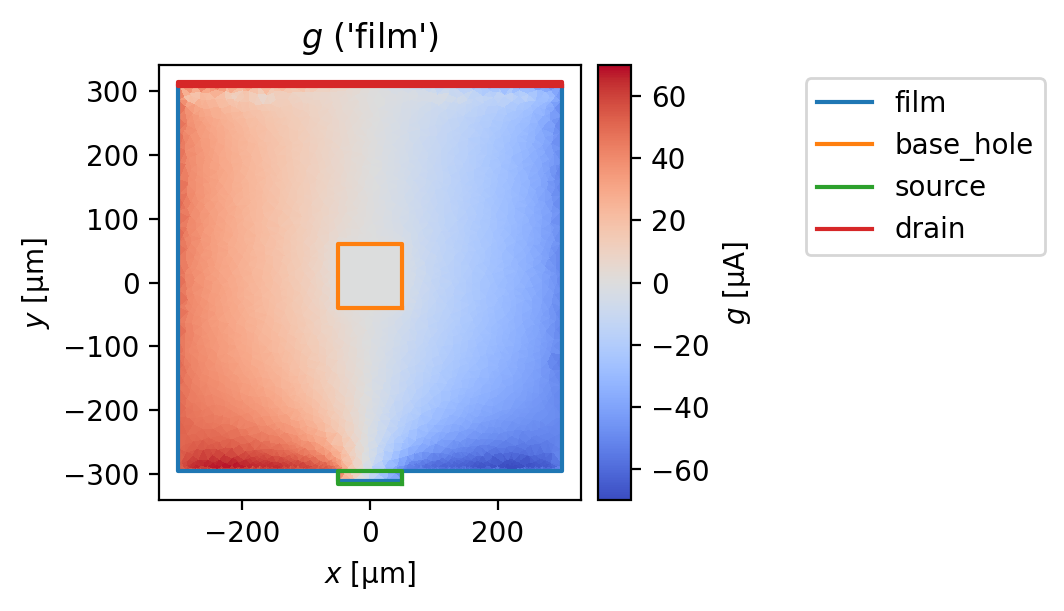

In [170]:
fig, axes = solution.plot_streams()
_ = device.plot_polygons(ax=axes[0])
_ = axes[0].legend(loc="upper left", bbox_to_anchor=(1.5, 1))

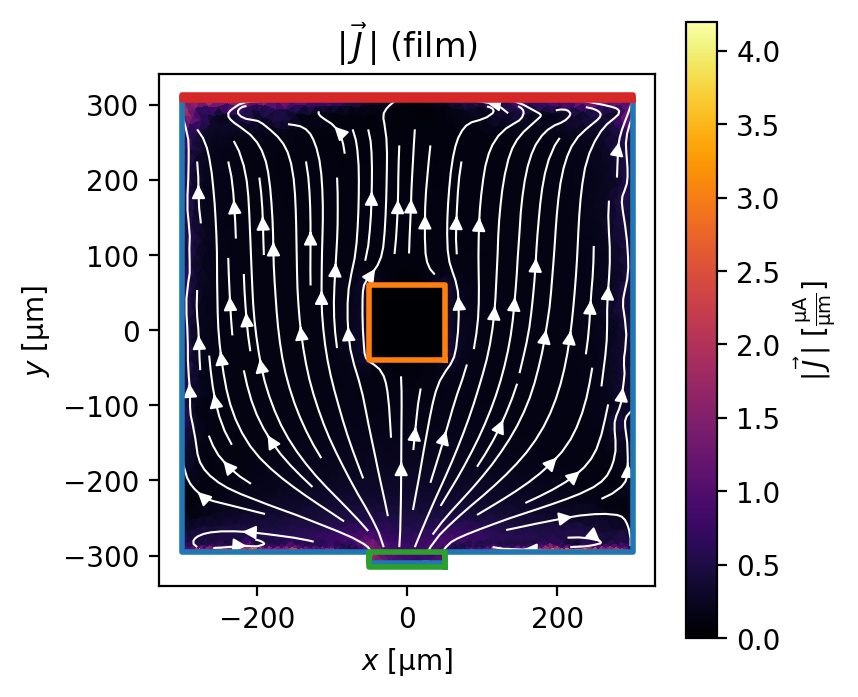

In [171]:
fig, axes = solution.plot_currents(streamplot=True)
_ = device.plot_polygons(ax=axes[0], lw=2)

In [172]:
eval_region = sc.Polygon(points=box(68, 40))
eval_mesh = eval_region.make_mesh(max_edge_length=1.5)
def solve_and_plot_model(source_current="200 uA", applied_field="0 uT"):

    # Solve the model
    terminal_currents = {"film": {"source": source_current, "drain": f"-{source_current}"}}
    applied_field = sc.ureg(applied_field).to("uT").magnitude
    model = sc.factorize_model(
        device=device,
        terminal_currents=terminal_currents,
        current_units="uA",
    )
    solution = sc.solve(
        model=model,
        applied_field=sc.sources.ConstantField(applied_field),
        field_units="uT",
    )[-1]

    # # Uncomment to find the zero-fluxoid solution.
    # solution = sc.find_fluxoid_solution(
    #     model,
    #     applied_field=sc.sources.ConstantField(applied_field),
    #     field_units="uT",
    # )

    # Define cross sections
    xs = np.linspace(-600 / 2, +600/ 2, 501)
    ys = np.ones_like(xs)
    sections = [
        np.array([xs, 300 * ys]).T,
        np.array([xs, 200* ys]).T,
        np.array([xs, 100 * ys]).T,
        np.array([xs, 0.0 * ys]).T,
    ]

    # Plot currents.
    fig, axes = solution.plot_currents(
        streamplot=True,
        min_stream_amp=1e-4,
        cross_section_coords=sections,
        figsize=(5, 4),
    )
    _ = device.plot_polygons(ax=axes[0], lw=1, color="w", ls="--")

    # Evaluate the current through each cross section.
    for coords in sections:
        total_current = solution.current_through_path(coords, film="film", units="uA").magnitude
        target_current = abs(solution.terminal_currents["film"]["source"])
        err = abs(total_current - target_current) / abs(target_current) * 100
        print(
            f"Cross-section: y = {coords[0, 1]:.2f} um, total current = {total_current:.3f} uA,target current = {target_current:.3f} uA"
            f" ({err:.2f}% error)"
        )
    
    # Plot fields
    fig, ax = solution.plot_field_at_positions(
        eval_mesh,
        zs=0.75,
        cross_section_coords=sections,
        figsize=(5, 4),
    )
    for coords in sections:
        axes[0].plot(coords[:, 0], coords[:, 1], 'r--')
    _ = device.plot_polygons(ax=ax, lw=1, color="w", ls="--")
    print(solution)
    return solution
    

Cross-section: y = 300.00 um, total current = -181.417 uA,target current = 200.000 uA (190.71% error)
Cross-section: y = 200.00 um, total current = -195.219 uA,target current = 200.000 uA (197.61% error)
Cross-section: y = 100.00 um, total current = -195.580 uA,target current = 200.000 uA (197.79% error)
Cross-section: y = 0.00 um, total current = -199.635 uA,target current = 200.000 uA (199.82% error)


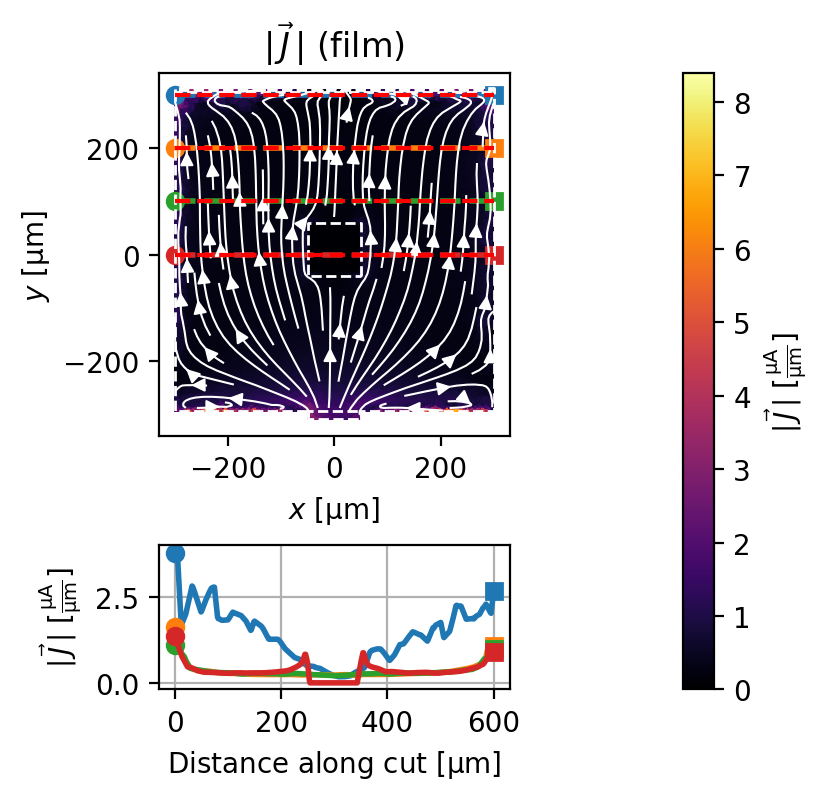

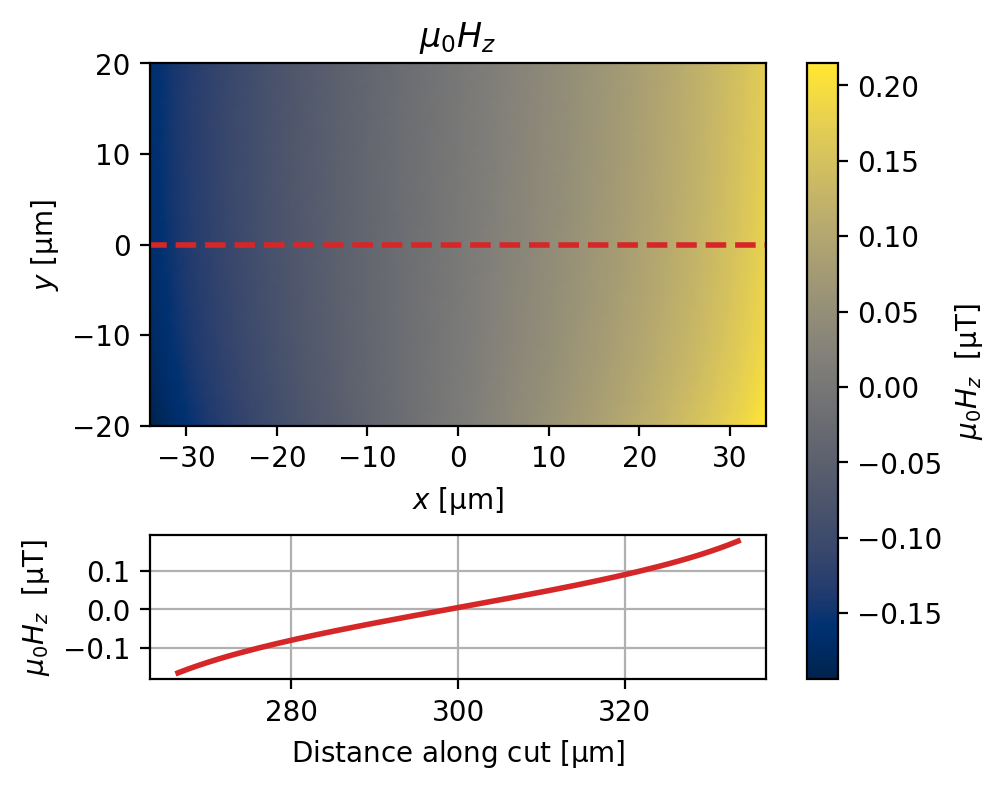

In [173]:
solution_0uT = solve_and_plot_model(source_current="200 uA", applied_field="0 uT")

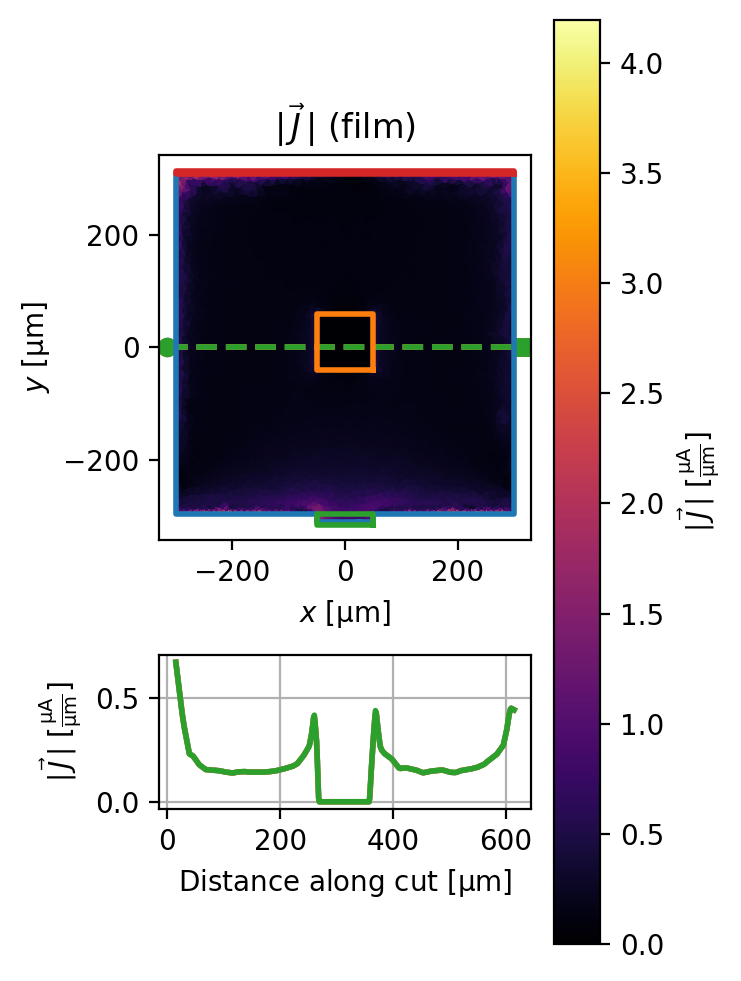

In [174]:
xs = np.linspace(-(1.05 * width) / 2, (1.05 * width) / 2, 501)
ys = np.ones_like(xs)

sections = [
    np.stack([xs, 0.6 * ys], axis=1),
    np.stack([xs, 0.3 * ys], axis=1),
    np.stack([xs, 0.0 * ys], axis=1),
]

fig, axes = solution.plot_currents(
    streamplot=False,
    cross_section_coords=sections,
    figsize=(3, 6),
)
_ = device.plot_polygons(ax=axes[0], lw=2)

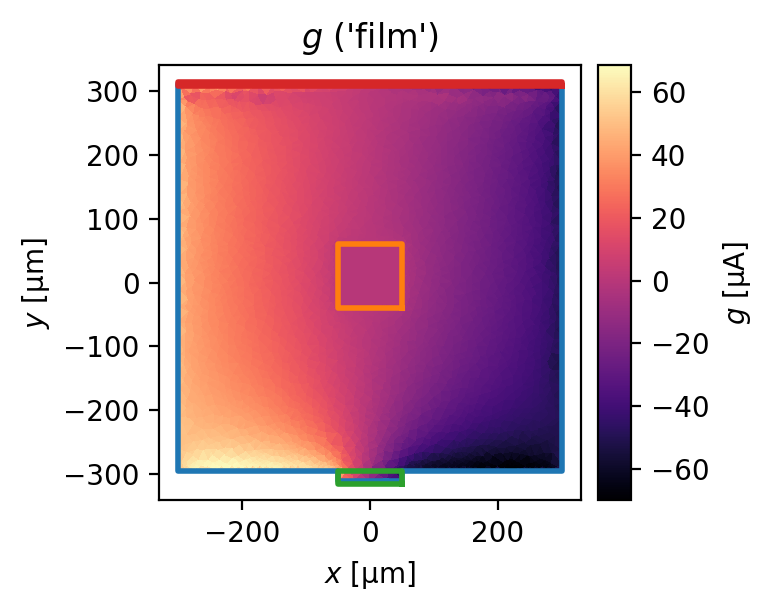

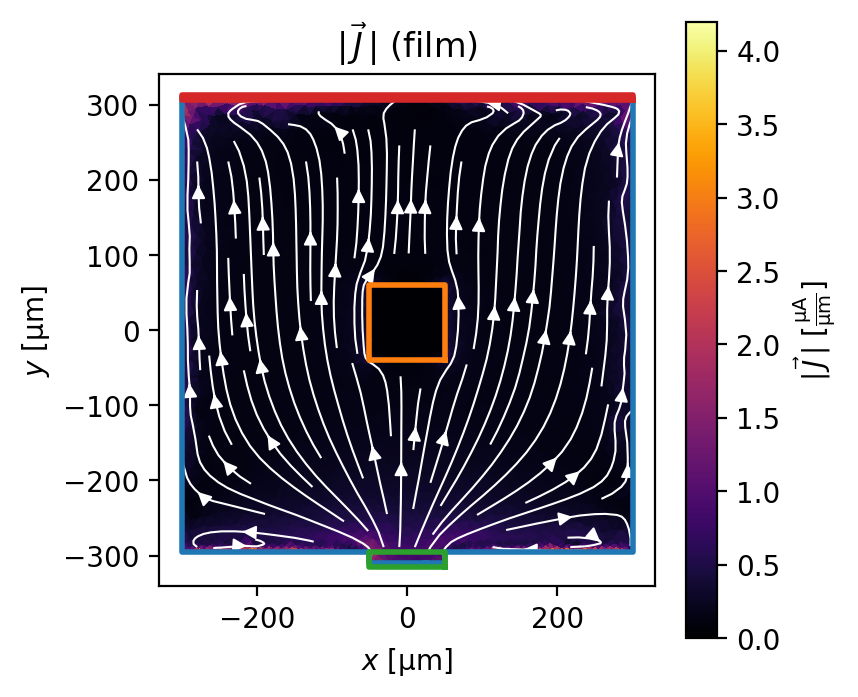

In [175]:
terminal_currents = {"film": {"source": "100 uA", "drain": "-100 uA"}}

model = sc.factorize_model(device=device, terminal_currents=terminal_currents, current_units="uA")

solution = sc.find_fluxoid_solution(
    model,
    applied_field=sc.sources.ConstantField(0),
)
fig, axes = solution.plot_streams(symmetric_color_scale=False, cmap="magma")
_ = device.plot_polygons(ax=axes[0], lw=2)
fig, axes = solution.plot_currents(streamplot=True)
_ = device.plot_polygons(ax=axes[0], lw=2)
